# Applying GIRAFFE on in silico data

In this notebook, we aim to investigate the performance of GIRAFFE on TODO artificial datasets. These datasets are designed to be representative of the underlying biology, and show that GIRAFFE performs well under those assumptions. We will use PANDA, OTTER, and the motif as comparisons. 

## 1. Load required packages

We load GIRAFFE and other required packages. PANDA and OTTER are available on netZooPy. Feel free to check [here](https://netzoopy.readthedocs.io/en/latest/install/index.html) for more information about installing netZooPy. 

In [1]:
import giraffe
from netZooPy.otter.otter import otter
from netZooPy.panda.panda import Panda 
import pandas as pd
import numpy as np
import scipy
from scipy import stats
from numpy.random import default_rng
import matplotlib.pyplot as plt
import random

## 3. Recovering ground-truth from projections

Again, we work with a small toy dataset. The dimensionality are picked to be coherent with the typical biological scenario. 

In [2]:
TF = 100
G = 500
n = 50

Similarly as before, we need to simulate the ground-truth regulation matrix R. We generate a sparse matrix, where non-zero entries are uniformly sampled in (0, 1). 

In [3]:
def generate_regulation(g, tf) :
    sparsity = 0.2
    rng = default_rng()
    rvs = stats.uniform(loc = 0, scale = 1).rvs
    R = scipy.sparse.random(g, tf, sparsity, random_state = rng, data_rvs = rvs).A
    return R

The motif is computed from the true regulation matrix by corrupting it with random uniform noise. 

In [4]:
def generate_motif(r):
    return r + np.random.uniform(-1, 1, (r.shape[0], r.shape[1]))

We decide that two proteins interact if they co-regulate "many" genes. To pick a proper threshold value, we plot the distribution of the number of co-regulated genes. 

In [5]:
R = generate_regulation(G, TF)

(0.0, 470.0)

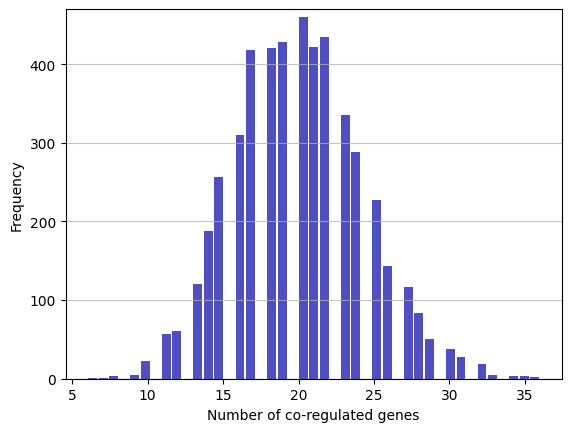

In [6]:
cooperation = []
R[R != 0] = 1
for i in range(TF):
    for j in range(i + 1, TF):
        cooperation.append(R[:, i].dot(R[:, j]))

"The following lines or code are taken from https://realpython.com/python-histograms/ [Accessed on Jan. 13th 2023]"
s, bins, patches = plt.hist(x = cooperation, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha = 0.75)
plt.xlabel('Number of co-regulated genes')
plt.ylabel('Frequency')
maxfreq = s.max()
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

We want a sparse PPI, so we (heuristically) pick 25 as threshold value. We now construct the PPI network. 

In [24]:
def generate_ppi(R):
    ppi = np.zeros((R.shape[1], R.shape[1]))
    R[R != 0] = 1
    for i in range(R.shape[1]):
        for j in range(R.shape[1]):
            if i == j :
                ppi[i, j] = 1 # By definition
            else :
                if R[:, i].dot(R[:, j]) >= 25:
                    ppi[i, j] = 1
    return ppi

Gene expressioned is sampled from a multi-normal distribution with mean zero and the same covariance as the regulation matrix. 

In [8]:
def generate_expression(C) :
    return np.random.multivariate_normal([0 for i in range(G)], C.T, n).T

Now we have generators for all required data: a ground-truth regulation, a motif, and a PPI netork. We are ready to put the pieces together in our simulation. 

In [27]:
def simulation() :
    R = generate_regulation(G, TF)
    ppi = generate_ppi(R)
    motif = generate_motif(R)
    expression = generate_expression(R.dot(R.T))

    otter_regulation = otter(motif.T, ppi, np.corrcoef(motif))
    giraffe_regulation = giraffe.Giraffe(expression, motif, ppi, lam = [0.000001, 5, 50, 1, 1]).get_regulation()
    #motif[motif >= np.quantile(motif, .6)] = 1 # PANDA requires a binary motif
    #panda_regulation = run_panda(R0, panda_motif, PPI, G, TF)
    print(giraffe_regulation.shape)
    return giraffe.evaluate_regulation_auroc(R, giraffe_regulation), giraffe.evaluate_regulation_auroc(R, otter_regulation.T), giraffe.evaluate_regulation_auroc(R, motif)

In [28]:
simulation()

(500, 100)


(0.8583376475, 0.7523665350000001, 0.7473188375)